# **1. Perkenalan Dataset**


Tahap pertama, Anda harus mencari dan menggunakan dataset **tanpa label** dengan ketentuan sebagai berikut:

1. **Sumber Dataset**:  
   Fish species sampling data - length and weight
   
2. **Ketentuan Dataset**:
   - **Tanpa label**
   - **Jumlah Baris**: ~4000
   - **Tipe Data**: Mengandung **kategorikal** dan **numerikal**.
     - *Kategorikal*: Jenis Ikan
     - *Numerikal*: Length, Weight etc

# **2. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [190]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression


# **3. Memuat Dataset**

In [191]:
df = pd.read_csv('fish/fish_data.csv')
print(df.head())
print(df.info())

              species  length  weight  w_l_ratio
0  Anabas testudineus   10.66    3.45       0.32
1  Anabas testudineus    6.91    3.27       0.47
2  Anabas testudineus    8.38    3.46       0.41
3  Anabas testudineus    7.57    3.36       0.44
4  Anabas testudineus   10.83    3.38       0.31
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4080 entries, 0 to 4079
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   species    4080 non-null   object 
 1   length     4080 non-null   float64
 2   weight     4080 non-null   float64
 3   w_l_ratio  4080 non-null   float64
dtypes: float64(3), object(1)
memory usage: 127.6+ KB
None


# **4. Exploratory Data Analysis (EDA)**

Pada tahap ini, Anda akan melakukan **Exploratory Data Analysis (EDA)** untuk memahami karakteristik dataset. EDA bertujuan untuk:

1. **Memahami Struktur Data**
   - Tinjau jumlah baris dan kolom dalam dataset.  
   - Tinjau jenis data di setiap kolom (numerikal atau kategorikal).

2. **Menangani Data yang Hilang**  
   - Identifikasi dan analisis data yang hilang (*missing values*). Tentukan langkah-langkah yang diperlukan untuk menangani data yang hilang, seperti pengisian atau penghapusan data tersebut.

3. **Analisis Distribusi dan Korelasi**  
   - Analisis distribusi variabel numerik dengan statistik deskriptif dan visualisasi seperti histogram atau boxplot.  
   - Periksa hubungan antara variabel menggunakan matriks korelasi atau scatter plot.

4. **Visualisasi Data**  
   - Buat visualisasi dasar seperti grafik distribusi dan diagram batang untuk variabel kategorikal.  
   - Gunakan heatmap atau pairplot untuk menganalisis korelasi antar variabel.

Tujuan dari EDA adalah untuk memperoleh wawasan awal yang mendalam mengenai data dan menentukan langkah selanjutnya dalam analisis atau pemodelan.

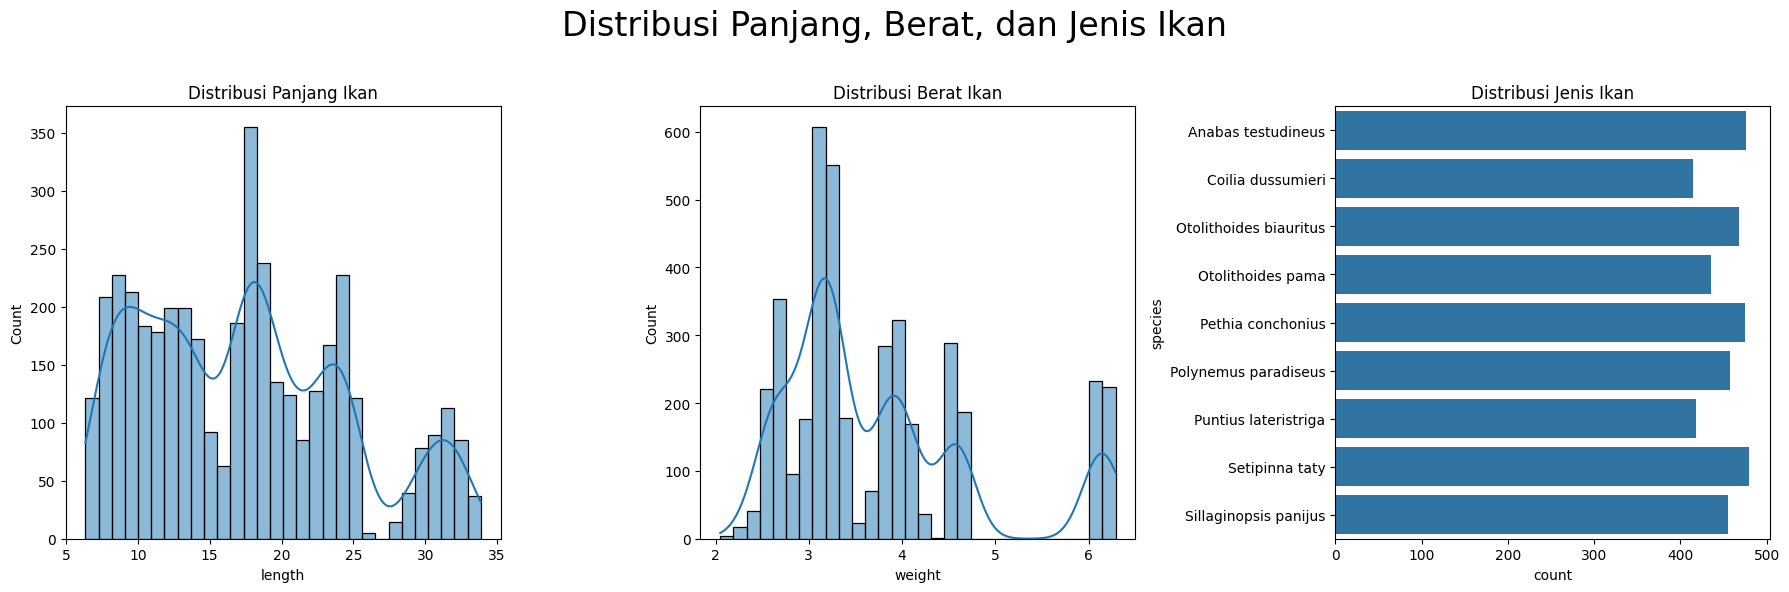

In [192]:
def distribusi():
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
    plt.suptitle('Distribusi Panjang, Berat, dan Jenis Ikan', fontsize=24)
    
    # Distribusi panjang ikan
    sns.histplot(df['length'], bins=30, kde=True, ax=axes[0])
    axes[0].set_title('Distribusi Panjang Ikan')
    
    # Distribusi berat ikan
    sns.histplot(df['weight'], bins=30, kde=True, ax=axes[1])
    axes[1].set_title('Distribusi Berat Ikan')
    
    # Distribusi jenis ikan
    sns.countplot(y='species', data=df, ax=axes[2])
    axes[2].set_title('Distribusi Jenis Ikan')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

distribusi()

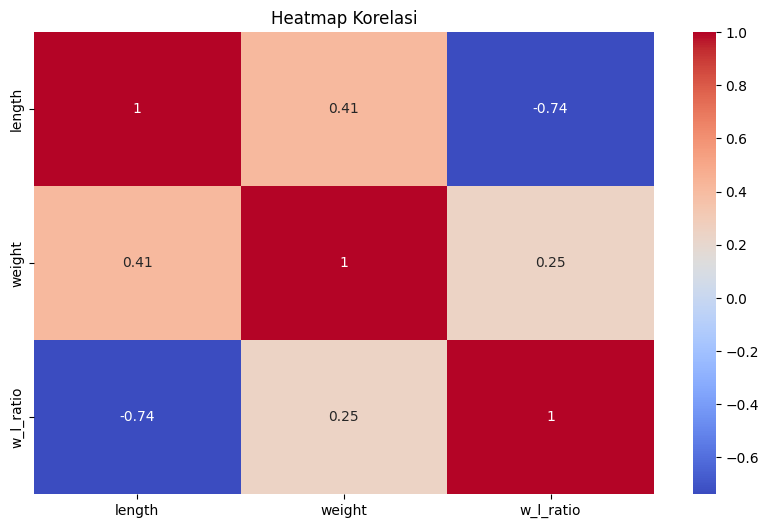

In [193]:
# Korelasi antar fitur
plt.figure(figsize=(10, 6))
sns.heatmap(df.drop(columns=['species']).corr(), annot=True, cmap='coolwarm')
plt.title('Heatmap Korelasi')
plt.show()

# **5. Data Preprocessing**

Pada tahap ini, data preprocessing adalah langkah penting untuk memastikan kualitas data sebelum digunakan dalam model machine learning. Data mentah sering kali mengandung nilai kosong, duplikasi, atau rentang nilai yang tidak konsisten, yang dapat memengaruhi kinerja model. Oleh karena itu, proses ini bertujuan untuk membersihkan dan mempersiapkan data agar analisis berjalan optimal.

Berikut adalah tahapan-tahapan yang bisa dilakukan, tetapi **tidak terbatas** pada:
1. Menghapus atau Menangani Data Kosong (Missing Values)
2. Menghapus Data Duplikat
3. Normalisasi atau Standarisasi Fitur
4. Deteksi dan Penanganan Outlier
5. Encoding Data Kategorikal
6. Binning (Pengelompokan Data)

Cukup sesuaikan dengan karakteristik data yang kamu gunakan yah.

In [194]:
# Encoding kolom kategorikal (species)
label_encoder = LabelEncoder()
df['species'] = label_encoder.fit_transform(df['species'])

# Normalisasi data numerik
scaler = StandardScaler()
df[['length', 'weight', 'w_l_ratio']] = scaler.fit_transform(df[['length', 'weight', 'w_l_ratio']])

# Menghapus data duplikat
df = df.drop_duplicates()

In [195]:
# Hapus kolom yang tidak perlu
df_cluster = df.drop(columns=['species'])

# Cek missing values
missing_values = df.isnull().sum()
print(missing_values)

# Standarisasi data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_cluster)
df_scaled = pd.DataFrame(scaled_data, columns=df_cluster.columns)

species      0
length       0
weight       0
w_l_ratio    0
dtype: int64


# **6. Pembangunan Model Clustering**

## **a. Pembangunan Model Clustering**

In [196]:
# Pilih fitur dan tambahkan transformasi log
df_cluster = df.drop(columns=['species', 'w_l_ratio'])
df_cluster['log_length'] = np.log(df_cluster['length'])
df_cluster['log_weight'] = np.log(df_cluster['weight'])
df_cluster = df_cluster.drop(columns=['length', 'weight'])

# Standarisasi
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_cluster)

C:\Users\favia\AppData\Roaming\Python\Python313\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\favia\AppData\Roaming\Python\Python313\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=5)
labels = dbscan.fit_predict(scaled_data)
if len(set(labels)) > 1:  # Pastikan ada klaster selain noise
    score = silhouette_score(scaled_data, labels)
    print(f"Silhouette Score (DBSCAN): {score:.2f}")
else:
    print("Tidak ditemukan klaster yang berarti.")

Silhouette Score (DBSCAN): 0.58


In [198]:
kmeans = KMeans(n_clusters=3, random_state=42)  # Contoh: k=3 berdasarkan skor tertinggi
clusters = kmeans.fit_predict(df_scaled)
df['cluster'] = clusters

## **b. Evaluasi Model Clustering**

In [199]:
from sklearn.metrics import silhouette_score

# Hitung Silhouette Score untuk berbagai jumlah klaster
silhouette_scores = []
for k in range(2, 11):  # Coba dari 2 hingga 10 klaster
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_data)
    score = silhouette_score(scaled_data, labels)
    silhouette_scores.append(score)
    print(f"k={k}, Silhouette Score: {score:.2f}")

# Plot hasil Silhouette Score
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Jumlah Klaster')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score untuk Menentukan Jumlah Klaster Optimal')
plt.show()

ValueError: Input X contains NaN.
KMeans does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

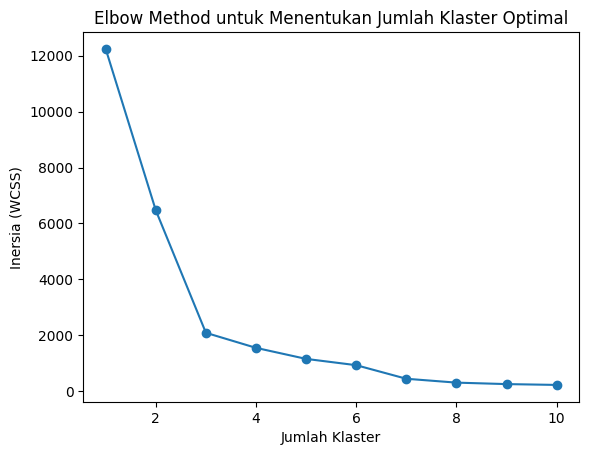

In [ ]:
# Hitung inersia untuk berbagai jumlah klaster
inertia_values = []
for k in range(1, 11):  # Coba dari 1 hingga 10 klaster
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia_values.append(kmeans.inertia_)

# Plot hasil Elbow Method
plt.plot(range(1, 11), inertia_values, marker='o')
plt.xlabel('Jumlah Klaster')
plt.ylabel('Inersia (WCSS)')
plt.title('Elbow Method untuk Menentukan Jumlah Klaster Optimal')
plt.show()

## **c. Feature Selection (Opsional)**

Silakan lakukan feature selection jika Anda membutuhkan optimasi model clustering. Jika Anda menerapkan proses ini, silakan lakukan pemodelan dan evaluasi kembali menggunakan kolom-kolom hasil feature selection. Terakhir, bandingkan hasil performa model sebelum dan sesudah menerapkan feature selection.

In [ ]:
#Type your code here

## **d. Visualisasi Hasil Clustering**

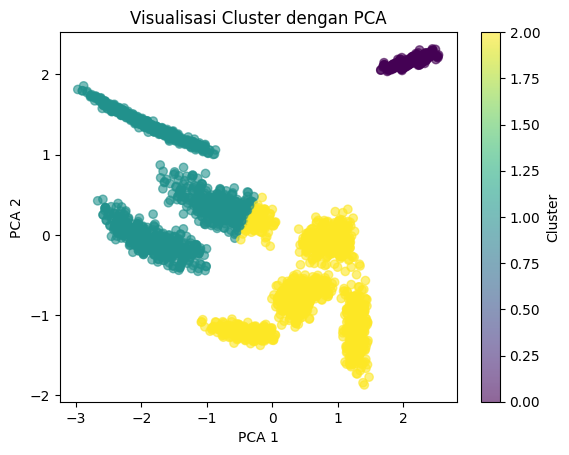

In [ ]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled)

plt.scatter(pca_result[:,0], pca_result[:,1], c=clusters, cmap='viridis', alpha=0.6)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Visualisasi Cluster dengan PCA')
plt.colorbar(label='Cluster')
plt.show()

## **e. Analisis dan Interpretasi Hasil Cluster**

### Interpretasi Target

In [ ]:
# Kembalikan data ke skala asli
df_inverse = pd.DataFrame(scaler.inverse_transform(df_scaled), columns=df_cluster.columns)
df_inverse['cluster'] = clusters

# Agregasi statistik per cluster
cluster_summary = df_inverse.groupby('cluster').agg(['mean', 'min', 'max'])
print(cluster_summary)

        log_length                     log_weight                    
              mean       min       max       mean       min       max
cluster                                                              
0         3.756898  3.701972  3.817480   1.172098  1.134322  1.217057
1         2.850688  2.468512  3.153310   1.615382  1.341160  2.085779
2         2.521127  2.068360  2.980048   1.118060  0.927483  1.320476


In [ ]:
X = df_inverse.drop(columns=['cluster'])
y = df_inverse['cluster']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    print(f"{name}:")
    print(f"  Akurasi (Train): {accuracy_score(y_train, y_pred_train):.2f}")
    print(f"  Akurasi (Test): {accuracy_score(y_test, y_pred_test):.2f}")
    print(f"  F1-Score (Train): {f1_score(y_train, y_pred_train, average='weighted'):.2f}")
    print(f"  F1-Score (Test): {f1_score(y_test, y_pred_test, average='weighted'):.2f}\n")

Logistic Regression:
  Akurasi (Train): 0.99
  Akurasi (Test): 0.99
  F1-Score (Train): 0.99
  F1-Score (Test): 0.99

Random Forest:
  Akurasi (Train): 1.00
  Akurasi (Test): 1.00
  F1-Score (Train): 1.00
  F1-Score (Test): 1.00



Tulis hasil interpretasinya di sini.
1. Cluster 1:
2. Cluster 2:
3. Cluster 3:

# Contoh interpretasi [TEMPLATE]
# Analisis Karakteristik Cluster dari Model KMeans

Berikut adalah analisis karakteristik untuk setiap cluster yang dihasilkan dari model KMeans.

## Cluster 1:
- **Rata-rata length**: 25.2 cm (min: 22.1, max: 33.8)
- **Rata-rata weight**: 5.8 kg (min: 5.1, max: 6.2)
- **Rata-rata w_l_ratio**: 0.23 (min: 0.18, max: 0.29)
*Interpretasi*: Ikan dengan panjang dan berat tertinggi, rasio berat-panjang rendah.

## Cluster 2:
- **Rata-rata length**: 12.5 cm (min: 6.3, max: 18.9)
- **Rata-rata weight**: 3.1 kg (min: 2.1, max: 4.0)
- **Rata-rata w_l_ratio**: 0.25 (min: 0.08, max: 0.35)
*Interpretasi*: Ikan kecil dengan berat sedang dan rasio bervariasi.

## Cluster 3:
- **Rata-rata length**: 19.8 cm (min: 15.0, max: 22.0)
- **Rata-rata weight**: 4.5 kg (min: 3.8, max: 5.0)
- **Rata-rata w_l_ratio**: 0.23 (min: 0.19, max: 0.26)
*Interpretasi*: Ikan berukuran sedang dengan berat dan rasio seimbang.

# **7. Mengeksport Data**

Simpan hasilnya ke dalam file CSV.